## Classification with the Adult dataset
To be handed until May 9 in edisciplinas: a write-up, five pages long at most, in pdf format, describing the results obtained in the following task:

1) Get the dataset Adult (either in the UCI Repository or in Kaggle).

2) Analyze features, missing data, and overall characteristics of the dataset (using tools in sklearn). Select features, discretize numerical features, handle missing data. 

3) Build a kNN classifier to predict class variable ">50k" (that is, whether person gets more than US$50k/year or not). Select the hyperparameter using cross-validation; test the final classifier using a holdout dataset.

4) Repeat (3) using three other classification techniques (for instance, neural network, classification tree, random forest, boosted trees, SVM, Naive Bayes).

5) Present accuracy, precision and recall for the best classifier in (3) and in (4).

## PCS5024 - Aprendizado Estatístico
 - Primeiro trimestre 2023 
 - Profs. Anna Helena Realli Costa e Fábio Gagliardi Cozman 
 - Aluno: Caio Azevedo - caio.aze@alumni.usp.br
 - Entrega em: 30.03.23

## Objetivo
 - Análise para classificação das pessoas que ganham mais de U$50k por ano. 
 - **Projeto Classificação Binária**

## Sobre o dataset

### Características descritivas
| Data Set Characteristics | Number of Instances | Attribute Characteristics | Number of Attributes | Associated Tasks | Missing Values? 
| --- | --- | --- | --- | --- | --- 
| Multivariate | 48842 | Categorical, Integer | 14 | Classification | Yes 

### Sobre os atributos

- **salary** (target): >50K, <=50K.

- **age**: continuous.
- **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- **fnlwgt**: continuous.
- **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, - -  - Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- **education-num**: continuous.
- **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- **race**: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- **sex**: Female, Male.
- **capital-gain**: continuous.
- **capital-loss**: continuous.
- **hours-per-week**: continuous.
- **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

## Referências:
 - https://archive.ics.uci.edu/ml/datasets/adult
 - https://archive.ics.uci.edu/ml/machine-learning-databases/adult/
 - http://www.cs.toronto.edu/~delve/data/adult/adultDetail.html
 - http://www.cs.toronto.edu/~delve/data/adult/desc.html
 - https://www.scaler.com/topics/data-science/categorical-missing-values/ 
 
 
 **Sobre balanceamento e classificação**
 - https://machinelearningmastery.com/imbalanced-classification-with-the-adult-income-dataset/
 - https://medium.com/analytics-vidhya/handle-missing-values-in-categorical-features-b7c5b073dda2
 **Sobre os modelos**
 - https://realpython.com/knn-python/

 boas implementações
 - https://www.kaggle.com/code/bhupendrarajput/complete-eda-and-machine-learning
 - https://arxiv.org/ftp/arxiv/papers/1810/1810.10076.pdf
 - https://github.com/itdxer/adult-dataset-analysis

## Implementação

### Importação bibliotecas

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [4]:
import os, sys
import pandas as pd
import missingno as msno
from sklearn.impute import SimpleImputer
%matplotlib inline

In [5]:
from functools import partial
from collections import defaultdict

import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn import metrics

### Constantes

In [6]:
#'https://raw.githubusercontent.com/Bhupendra1770/Adult-Census-Income-Prediction/main/adult.csv'
APP_PATH = os.getcwd()
DATA_DIR = os.path.join(APP_PATH, 'data')
TRAIN_DATA_FILE = os.path.join(DATA_DIR, 'adult.data.csv')
TEST_DATA_FILE = os.path.join(DATA_DIR, 'adult.test.csv')
target_column = "income"

### Considerações para implementação do classificador

- O atributo fnlwgt será removido para implementação da classificação, seja porque sua definição não agrega valor à predição, seja pela análise estatística que provou sua baixa correlação ao atributo target.
- O atributo education-num também será removido pois seu valor já está representado com o atributo education
- O atributo native-country será transformado em um atributo binário chamado fromUS, cujo valor será 1 quando native_country for igual a United-States e 0 caso contrário.
- Os atributos capital-gain e capital-loss, também são candidatos a exclusão pois concentram seu dominio em um único valor (zero)
- Registros duplicados e impossíveis de classificar também devem ser removidos da amostra de treino.
- Deve-se testar pelo menos duas abordagens para tratamento dos registros com NaN e utilizar o de melhor desempenho do classificador.
- O atributo target deve ser tratado e seu valor convertido em 1 ou 0


### Gráficos das métricas

In [7]:
def plot_confusion_matrix_and_evaluation_metrics(actual,prediction):
    #compute the confusion matrix.
    cm = confusion_matrix(actual,prediction)
 
    #Plot the confusion matrix.
    sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['>50k','<50k'],
            yticklabels=['>50k','<50k'])
    plt.ylabel('Prediction',fontsize=13)
    plt.xlabel('Actual',fontsize=13)
    plt.title('Confusion Matrix',fontsize=17)
    plt.show()

    accuracy = accuracy_score(actual, prediction)
    print("Accuracy   :", accuracy)
    precision = precision_score(actual, prediction)
    print("Precision :", precision)
    recall = recall_score(actual, prediction)
    print("Recall    :", recall)
    F1_score = f1_score(actual, prediction)
    print("F1-score  :", F1_score)
    ROC_score = roc_auc_score(actual, prediction)
    print("ROC AUC  :", ROC_score)

In [8]:
def check_feature_importance(linear_classifier, feature_names):
    xs = np.arange(len(feature_names))
    plt.title("Importancia das variáveis (para o último fold)")
    plt.barh(xs, linear_classifier.coef_[0])
    plt.yticks(xs, feature_names)

In [9]:
def plot_precision_recall_curves(pr_curves):
    curves = []
    for precision, recall in pr_curves:
        curve, = plt.plot(recall, precision)
        curves.append(curve)
        
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.legend(curves, ['Fold #{}'.format(i) for i in range(1, len(curves) + 1)])
    plt.tight_layout()

In [10]:
def plot_f1_curves(f1_curves, thresholds):
    curves = []
    for f1_values in f1_curves:
        curve, = plt.plot(thresholds, f1_values)
        curves.append(curve)

    plt.legend(curves, ['Fold #{}'.format(i) for i in range(1, len(curves) + 1)])
    plt.ylabel('F1')
    plt.xlabel('Threshold da classificação')
    plt.tight_layout()

In [11]:
def plot_kappa_curves(kappa_curves, thresholds):
    curves = []
    for kappa_values in kappa_curves:
        curve, = plt.plot(thresholds, kappa_values)
        curves.append(curve)

    plt.legend(curves, ['Fold #{}'.format(i) for i in range(1, len(curves) + 1)])
    plt.ylabel('Kappa')
    plt.xlabel('Threshold da classificação')
    plt.tight_layout()

In [12]:
# Code from: https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/separation_plot.py
# Code was reformated in order to fit better into general code style
def separation_plot( p, y, **kwargs ):
    """
    This function creates a separation plot for logistic and probit classification. 
    See http://mdwardlab.com/sites/default/files/GreenhillWardSacks.pdf
    
    p: The proportions/probabilities, can be a nxM matrix which represents M models.
    y: the 0-1 response variables.
    
    """
    p = p.flatten()
    y = y.flatten()
    n = p.size

    colors_bmh = np.array(["#eeeeee", "#348abd"])
    ix = np.argsort(p)
    ax = plt.gca()

    # plot the different bars
    bars = ax.bar(
        np.arange(n),
        np.ones(n),
        width=1.,
        color=colors_bmh[y[ix].astype(int)], 
        edgecolor='none'
    )
    ax.plot(
        np.arange(n + 1),
        np.append(p[ix], p[ix][-1]),
        "k",
        linewidth=1.,
        drawstyle="steps-post"
    )

    # create expected value bar.
    ax.vlines([(1 - p[ix]).sum()], [0], [1])
    plt.xlim(0, n)
        
    plt.tight_layout()

### Validação dos modelos

In [13]:
def collect_metrics(fold_metrics, actual, predicted_proba, thresholds):
    kappa_score = partial(metrics.cohen_kappa_score, actual)
    
    fold_metrics['roc_scores'].append(metrics.roc_auc_score(actual, predicted_proba))
    fold_metrics['f1_scores'].append(metrics.f1_score(actual, predicted_proba.round()))
    fold_metrics['kappa'].append(kappa_score(predicted_proba.round()))
    fold_metrics['accuracy'].append(metrics.accuracy_score(actual, predicted_proba.round()))
    fold_metrics['precision'].append(metrics.precision_score(actual, predicted_proba.round()))
    fold_metrics['recall'].append(metrics.recall_score(actual, predicted_proba.round()))

    precision, recall, _ = metrics.precision_recall_curve(actual, predicted_proba)
    kappa_values = [kappa_score(predicted_proba > threshold) for threshold in thresholds]
    f1_values = [metrics.f1_score(actual,  predicted_proba > threshold) for threshold in thresholds]
    
    fold_metrics['pr_curves'].append((precision, recall))
    fold_metrics['kappa_curves'].append(kappa_values)
    fold_metrics['f1_curves'].append(f1_values)
    
def print_last_fold_stats(fold_metrics):
    print("ROC AUC score : {:.3f}".format(fold_metrics['roc_scores'][-1]))
    print("Kappa score   : {:.3f}".format(fold_metrics['kappa'][-1]))
    print("F1 score      : {:.3f}".format(fold_metrics['f1_scores'][-1]))
    print("Accuracy      : {:.3f}".format(fold_metrics['accuracy'][-1]))
    print("Precision      : {:.3f}".format(fold_metrics['precision'][-1]))
    print("Recall      : {:.3f}".format(fold_metrics['recall'][-1]))

def validate_model(model, X, y):
    kfold = KFold(n_splits=4, shuffle=True)
    fold_metrics= defaultdict(list)
    thresholds = np.arange(0.1, 1, 0.1)
    
    for i, (train_index, valid_index) in enumerate(kfold.split(X), start=1):
        x_train, x_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]

        if isinstance(model, lgb.LGBMClassifier):
            # From the LGB we can get plot that shows progress
            # for training and validation data.
            # We don't show it, but information can be available
            # from the model.
            model.fit(
                x_train, y_train,
                eval_set=[(x_train, y_train), (x_valid, y_valid)],
                verbose=False,
            )
        else:
            model.fit(x_train, y_train)

        x_predicted_probas = model.predict_proba(x_valid)
        x_predicted_proba = x_predicted_probas[:, 1]

        collect_metrics(fold_metrics, y_valid, x_predicted_proba, thresholds)
        
        print("Fold #{}".format(i))
        print_last_fold_stats(fold_metrics)
        print('-' * 30)
        
    print("")
    print("ROC AUC médio entre os folds  : {:.3f}".format(np.mean(fold_metrics['roc_scores'])))
    print("Kappa médio entre os folds    : {:.3f}".format(np.mean(fold_metrics['kappa'])))
    print("F1 médio entre os folds       : {:.3f}".format(np.mean(fold_metrics['f1_scores'])))
    print("Acurácia média entre os folds : {:.3f}".format(np.mean(fold_metrics['accuracy'])))
    print("Precision média entre os folds : {:.3f}".format(np.mean(fold_metrics['precision'])))
    print("Recall média entre os folds : {:.3f}".format(np.mean(fold_metrics['recall'])))
    
    
    plt.figure(figsize=(14, 8))
    
    plt.subplot(221)
    plt.title("Separation plot for last fold")
    separation_plot(x_predicted_proba, y_valid)
    
    plt.subplot(222)
    plt.title("Curvas Precision-recall")
    plot_precision_recall_curves(fold_metrics['pr_curves'])
    
    plt.subplot(223)
    plt.title("Kappa para os diferentes thresholds")
    plot_kappa_curves(fold_metrics['kappa_curves'], thresholds)
    
    plt.subplot(224)
    plt.title("F1 para os diferentes thresholds")
    plot_f1_curves(fold_metrics['f1_curves'], thresholds)

    plt.show()

### Funções de Encoding

In [14]:
def get_categorical_columns(data, cat_columns=None, fillna=True):
    if cat_columns is None:
        cat_data = data.select_dtypes('category')
    else:
        cat_data = data[cat_columns]

    if fillna:
        for colname, series in cat_data.iteritems():
            if 'Other' not in series.cat.categories:
                series = series.cat.add_categories(['Other'])

            cat_data[colname] = series.fillna('Other')
            
    return cat_data

In [15]:
#https://pythonsimplified.com/difference-between-onehotencoder-and-get_dummies/
def features_with_one_hot_encoded_categories(data, num_columns, cat_columns=None, fillna=True):
    #numerical_data = data[num_columns]
    cat_data = data[cat_columns]
    one_hot_data = pd.get_dummies(cat_data) #trocar por onehot com objeto instanciado fora da função e chamado aqui. 
    df = pd.concat([data, one_hot_data], axis=1)
    
    features = num_columns + one_hot_data.columns.tolist()

    X = df[features].fillna(0).values.astype(float)
    y = df[target_column].values
    
    return X, y

In [16]:
def features_with_labeled_categories(data, num_columns, cat_columns=None, fillna=True):
    #cat_data = get_categorical_columns(data, cat_columns, fillna)
    cat_data = data[cat_columns]
    cat_labeled_data = cat_data.apply(lambda x: x.cat.codes)
    
    numerical_data = data[num_columns]
    
    if fillna:
        numerical_data = numerical_data.fillna(0)
    
    X = np.concatenate([
        numerical_data.values.astype(float),
        cat_labeled_data.values,
    ], axis=1)
    y = data[target_column].values

    feature_names = num_columns + cat_data.columns.tolist()
    return X, y, feature_names

### Leitura e tratamento das amostras

In [17]:
def read_dataset(path):
    return pd.read_csv(
        path,
        index_col=None,
        comment='|',  
        skipinitialspace=True,  
        na_values={
            'capital-gain': 99999,
            'workclass': '?',
            'native-country': '?',
            'occupation': '?',
        },
    )

def clean_dataset(data):

    #remove eventuais espaços vazios no inicio e/ou fim das colunas do tipo string 'object'
    for i in data.columns:
        if data[i].dtype=='object':
            data[i] = data[i].str.strip()
            #data[i] = data[i].astype("category")

    # Por algum motivo o dataset de teste tem um ponto (.) no final do atributo target, sendo necessário remove-lo
    data[target_column] = data.income.str.rstrip('.')
    
    # Remoção das colunas colunas abaixo, pois entendemos que elas não são 
    # relevantes para classificação.
    data = data.drop('fnlwgt', axis=1)
    data = data.drop('education-num', axis=1)
    data = data.drop('capital-gain', axis=1)
    data = data.drop('capital-loss', axis=1)
    
    # Registros duplicados podem gerar viés na analise e classificação, 
    # logo devem ser removidos
    data = data.drop_duplicates()
    
    # "Binariza" o atributo target  (>50K == 1 e <=50K == 0)
    data[target_column] = (data[target_column] == '>50K').astype(int)

    return data

#train_data = clean_dataset(read_dataset(TRAIN_DATA_FILE))
#test_data = clean_dataset(read_dataset(TEST_DATA_FILE))

#data = train_data

In [18]:
def mergedataset(train_data, test_data):
    train_data['is_test'] = 0
    test_data['is_test'] = 1
    data = pd.concat([train_data, test_data])
    return data

In [19]:
def deduplicate(merged_data):

    for i in merged_data.columns:
        if merged_data[i].dtype=='object':
            merged_data[i] = merged_data[i].str.strip()
            data[i] = data[i].astype("category")
    
    train_data = merged_data[merged_data.is_test == 0].drop('is_test', axis=1)
    test_data = merged_data[merged_data.is_test == 1].drop('is_test', axis=1)
    return train_data, test_data

In [20]:
train_data = clean_dataset(read_dataset(TRAIN_DATA_FILE))
test_data = clean_dataset(read_dataset(TEST_DATA_FILE))
print("Percentual da variável target positivas na amostra de treino: {:.2%}".format(np.mean(train_data.income)))
print("Percentual da variável target positivas na amostra de teste: {:.2%}".format(np.mean(test_data.income)))

Percentual da variável target positivas na amostra de treino: 23.77%
Percentual da variável target positivas na amostra de teste: 23.38%


In [21]:
data = mergedataset(train_data, test_data)
print("Total de registros da amostra: {:}".format(data.shape[0]))
print("Percentual da variável target positivas na amostra: {:.2%}".format(np.mean(data.income)))

Total de registros da amostra: 43329
Percentual da variável target positivas na amostra: 23.64%


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43329 entries, 0 to 16280
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             43329 non-null  int64 
 1   workclass       40854 non-null  object
 2   education       43329 non-null  object
 3   marital-status  43329 non-null  object
 4   occupation      40844 non-null  object
 5   relationship    43329 non-null  object
 6   race            43329 non-null  object
 7   sex             43329 non-null  object
 8   hours-per-week  43329 non-null  int64 
 9   native-country  42476 non-null  object
 10  income          43329 non-null  int32 
 11  is_test         43329 non-null  int64 
dtypes: int32(1), int64(3), object(8)
memory usage: 4.1+ MB


<AxesSubplot:>

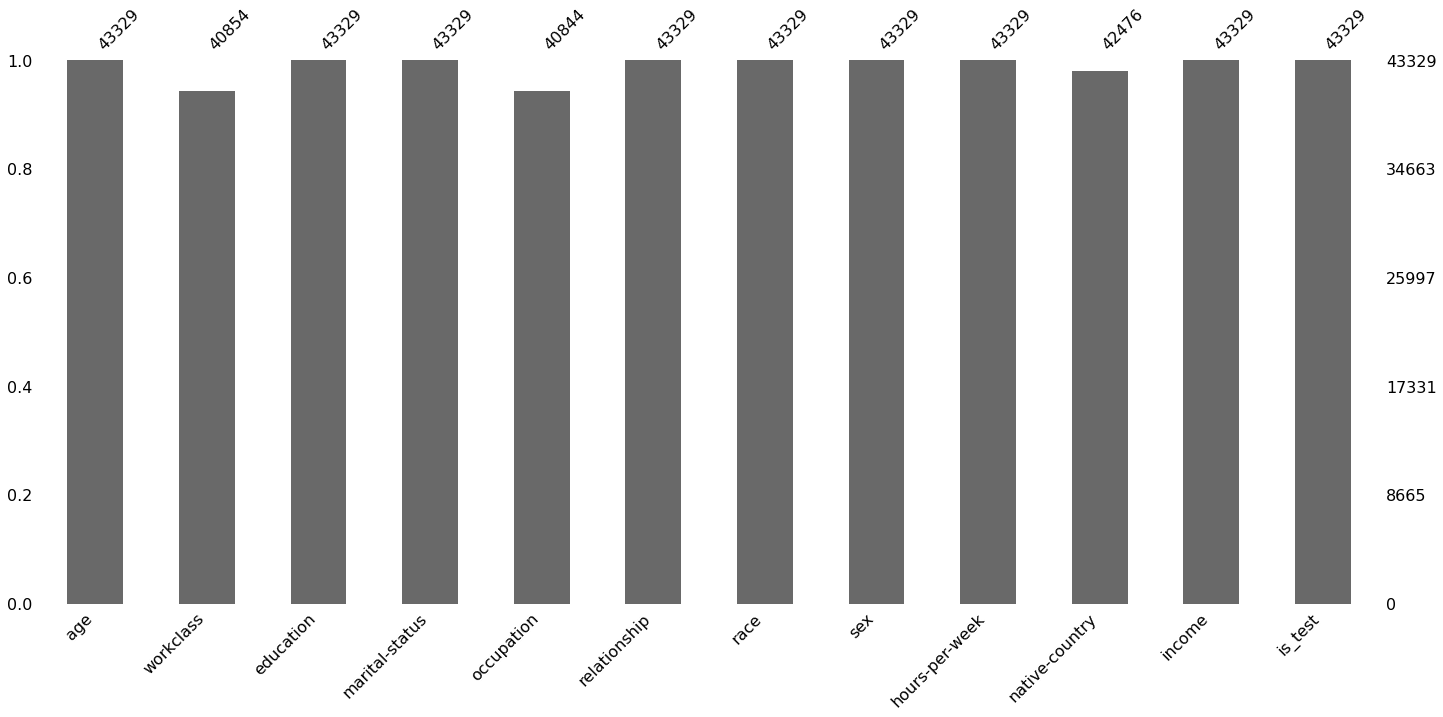

In [23]:
#visualiza a quantidade de registros nulos por atributo
msno.bar(data)

In [24]:
#total de registros nulos por atributo. 
data.isnull().sum()

age                  0
workclass         2475
education            0
marital-status       0
occupation        2485
relationship         0
race                 0
sex                  0
hours-per-week       0
native-country     853
income               0
is_test              0
dtype: int64

### Feature Engineering

#### Tratando dados faltantes
 - optaremos por três abordagens para o tratamento dos dados faltantes, visto que todos eles são categoricos.
 1. remoção dos registros que possuam pelo menos um dado faltante.
 2. preencher os dados faltantes pelo mais frequente na amostra (moda)
 3. preencher os dados faltantes por meio de um modelo de classificação (RandomForest ou LogistcRegression)
 
 - as abordagens 2 e 3 foram consideradas, uma vez que somente menos que 1% (30162/32561) da amostra possui dados faltantes.
 - para efeito de classificação, será considerada a abordagem que resultar no melhor desempenho dos modelos utilizados

In [25]:
#dropnulls | most_frequent | 
lang = "dropnulls"

match lang:
    case "dropnulls":
        data.dropna(axis=0, inplace=True)
        data.isnull().sum()
        print("nulos apagados")

    case "most_frequent":
        impute_mode = SimpleImputer(strategy = 'most_frequent')
        impute_mode.fit(data[['workclass', 'occupation','native-country']])
        data[['workclass', 'occupation','native-country']] = impute_mode.transform(data[['workclass', 'occupation','native-country']])
        print("nulos preenchidos com os registros mais frequentes")

    case _:
        # To perform KNN imputation, we need to normalize the input data and perform One Hot Encoding to categorical variables
        #from sklearn.impute import KNNImputer
        #imputer = KNNImputer(n_neighbors = 3)
        #df = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)
        #X = df.drop("workclass", axis=1).values
        #Y = df["workclass"].values
        #X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
        #forest = RandomForestClassifier(n_estimators=45, max_depth=25, random_state=False, max_features=0.6, min_samples_leaf=3, n_jobs=-1)
        #forest.fit(X_train, Y_train)
        print("nenhuma das opções válidas")

nulos apagados


<AxesSubplot:>

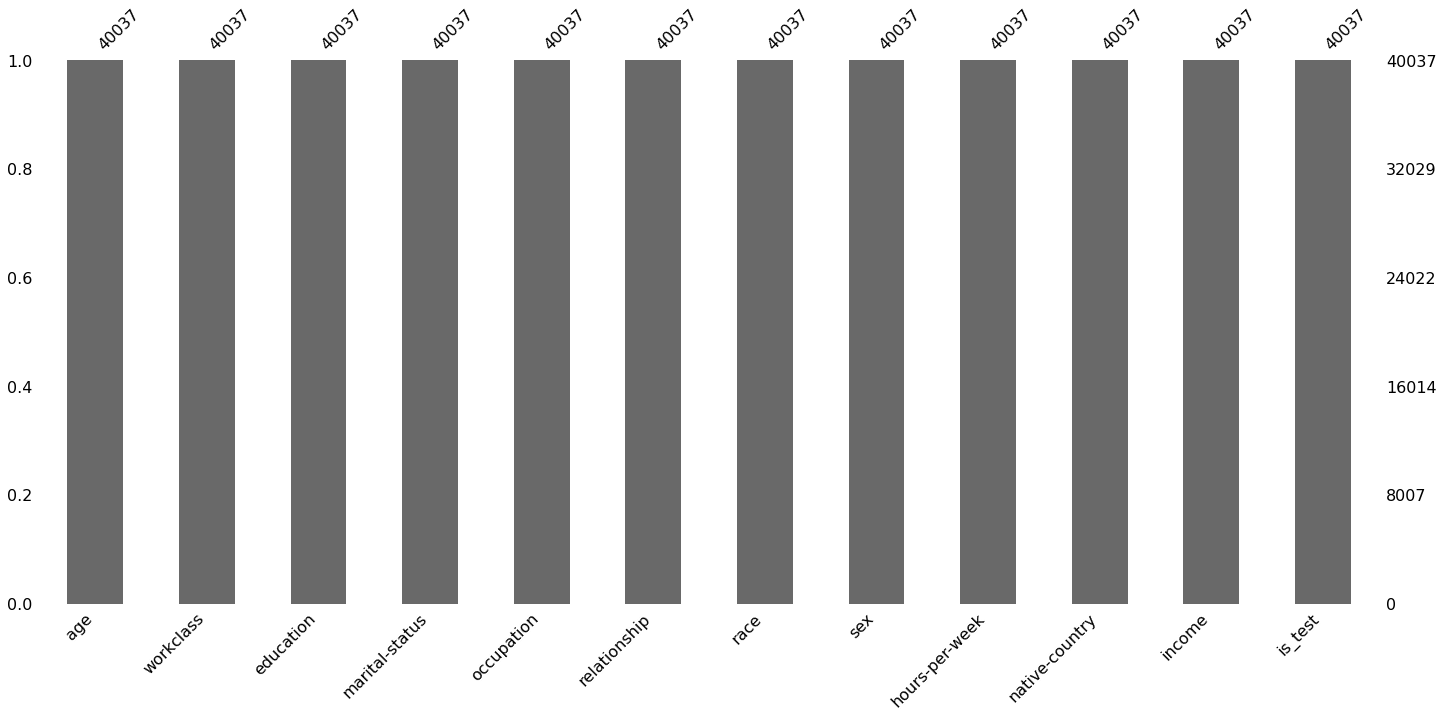

In [26]:
msno.bar(data)

#### Reestruturando atributos

In [27]:
data['fromUS'] = (data['native-country'] == 'United-States').astype(int)
data = data.drop('native-country', axis=1)

- Atributo educatio: as categorias de menor instrução, abaixo do colegial (high school ou 'HS-grad'), sendo agrupadas em uma única classe ('School')

In [28]:
data['education'].replace(['11th', '9th', '7th-8th', '5th-6th', '10th', '1st-4th', 'Preschool', '12th'],
                             ' School', inplace = True)

#### Registros de classificação impossível

In [29]:
all_columns = data.columns.tolist()
#exclui as variáveis target e a de separação das amostras, antes de computar os registros n-plicados
predictor_columns = list(set(all_columns).difference([target_column,'is_test']))   
column_frequency = (data
    .groupby(predictor_columns, as_index=False)
    .agg({target_column: 'nunique'}))

column_frequency[column_frequency.income > 1].shape[0]

1385

In [30]:
column_frequency[column_frequency.income > 1]

,marital-status,fromUS,occupation,age,sex,workclass,relationship,race,education,hours-per-week,income
485,Divorced,1,Adm-clerical,32,Female,Private,Not-in-family,White,HS-grad,38,2
561,Divorced,1,Adm-clerical,35,Female,Private,Not-in-family,White,Some-college,40,2
693,Divorced,1,Adm-clerical,39,Male,Private,Not-in-family,White,HS-grad,40,2
841,Divorced,1,Adm-clerical,44,Female,Private,Unmarried,White,HS-grad,40,2
1051,Divorced,1,Adm-clerical,51,Female,Private,Unmarried,White,Some-college,40,2
...,...,...,...,...,...,...,...,...,...,...,...
32801,Never-married,1,Tech-support,31,Female,Private,Not-in-family,White,Bachelors,40,2
33091,Never-married,1,Transport-moving,25,Male,Private,Not-in-family,White,Some-college,50,2
33660,Separated,1,Adm-clerical,55,Female,Private,Not-in-family,White,HS-grad,40,2
34962,Widowed,1,Adm-clerical,64,Female,Private,Not-in-family,White,HS-grad,40,2


In [31]:
income_cnt = data.groupby(predictor_columns)[target_column].size()

In [32]:
income_cnt[income_cnt > 1]

marital-status  fromUS  occupation         age  sex     workclass  relationship   race   education     hours-per-week
Divorced        0       Craft-repair       57   Male    Private    Unmarried      White   School       40                2
                1       Adm-clerical       25   Female  Private    Unmarried      White  Assoc-voc     40                2
                                           26   Female  Private    Not-in-family  White  Some-college  40                2
                                           28   Female  Private    Not-in-family  White  HS-grad       40                2
                                                                   Unmarried      White  Some-college  40                2
                                                                                                                        ..
Widowed         1       Machine-op-inspct  59   Female  Private    Not-in-family  White  HS-grad       40                2
                     

In [33]:
#exemplo de um dos registros de treino impossível de classificar
impossible = data[(data['hours-per-week']==70) & (data['education']=='Bachelors') & (data['occupation']=='Exec-managerial') \
      & (data['sex']=='Male') & (data['workclass']=='Private') & (data['age']==39) & (data['race']=='White') \
      & (data['fromUS']==1) & (data['marital-status']=='Married-civ-spouse') & (data['relationship']=='Husband')]

impossible

,age,workclass,education,marital-status,occupation,relationship,race,sex,hours-per-week,income,is_test,fromUS
6901,39,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,70,0,0,1
24105,39,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,70,1,0,1
2818,39,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,70,1,1,1


In [34]:
predictor_columns

['marital-status',
 'fromUS',
 'occupation',
 'age',
 'sex',
 'workclass',
 'relationship',
 'race',
 'education',
 'hours-per-week']

In [35]:
#por não termos um critério seguro para manutenção das classificações n-plicadas, optamos por excluir todas elas.
data = data.drop_duplicates(subset=predictor_columns, keep=False)

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32749 entries, 0 to 16280
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32749 non-null  int64 
 1   workclass       32749 non-null  object
 2   education       32749 non-null  object
 3   marital-status  32749 non-null  object
 4   occupation      32749 non-null  object
 5   relationship    32749 non-null  object
 6   race            32749 non-null  object
 7   sex             32749 non-null  object
 8   hours-per-week  32749 non-null  int64 
 9   income          32749 non-null  int32 
 10  is_test         32749 non-null  int64 
 11  fromUS          32749 non-null  int32 
dtypes: int32(2), int64(3), object(7)
memory usage: 3.0+ MB


In [37]:
print("Total de registros restantes na amostra: {:}".format(data.shape[0]))
print("Percentual da variável target positivas na amostra: {:.2%}".format(np.mean(data.income)))

Total de registros restantes na amostra: 32749
Percentual da variável target positivas na amostra: 22.54%


In [38]:
train_data, test_data = deduplicate(data)

In [39]:
print("Total de registros restantes na amostra de treino: {:}".format(train_data.shape[0]))
print("Total de registros restantes na amostra de teste: {:}".format(test_data.shape[0]))

Total de registros restantes na amostra de treino: 21943
Total de registros restantes na amostra de teste: 10806


In [40]:
print("Percentual da variável target positivas na amostra de treino: {:.2%}".format(np.mean(train_data.income)))
print("Percentual da variável target positivas na amostra de teste: {:.2%}".format(np.mean(test_data.income)))

Percentual da variável target positivas na amostra de treino: 22.78%
Percentual da variável target positivas na amostra de teste: 22.05%


In [41]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10806 entries, 0 to 16280
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             10806 non-null  int64   
 1   workclass       10806 non-null  category
 2   education       10806 non-null  category
 3   marital-status  10806 non-null  category
 4   occupation      10806 non-null  category
 5   relationship    10806 non-null  category
 6   race            10806 non-null  category
 7   sex             10806 non-null  category
 8   hours-per-week  10806 non-null  int64   
 9   income          10806 non-null  int32   
 10  fromUS          10806 non-null  int32   
dtypes: category(7), int32(2), int64(2)
memory usage: 413.8 KB


In [42]:
data = data.reindex(columns=predictor_columns)

In [43]:
print("Total registros: {:d}, Treino: {:03d} e Teste: {:d}".format(data.shape[0], train_data.shape[0],test_data.shape[0]))

Total registros: 32749, Treino: 21943 e Teste: 10806


#### Identifica as covariáveis categóricas  e numéricas

In [44]:
# Armazena os atributos categóricos dentre os atributos preditores
cat_col=[]
for i in train_data.columns:
    if train_data[i].dtype=='category':
        cat_col.append(i)
cat_col

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex']

In [45]:
# Armazena os atributos numéricos dentre os atributos preditores
num_col=[]
for colname, column_series in train_data._get_numeric_data().items():
    num_col.append(colname)
    
num_col.remove(target_column)
num_col  

['age', 'hours-per-week', 'fromUS']

### Aplicação Modelos

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [47]:
#X_train, y_train, feature_names = features_with_labeled_categories(train_data, num_col,cat_col)
X_train, y_train = features_with_one_hot_encoded_categories(train_data, num_col,cat_col)
X_train

array([[39., 40.,  1., ...,  1.,  0.,  1.],
       [50., 13.,  1., ...,  1.,  0.,  1.],
       [53., 40.,  1., ...,  0.,  0.,  1.],
       ...,
       [27., 38.,  1., ...,  1.,  1.,  0.],
       [58., 40.,  1., ...,  1.,  1.,  0.],
       [52., 40.,  1., ...,  1.,  1.,  0.]])

In [48]:
#X_train, y_train, feature_names = features_with_labeled_categories(train_data, num_col,cat_col)
#X_train, y_train = features_with_one_hot_encoded_categories(train_data, num_col,cat_col)
X_train = sc.fit_transform(X_train)
X_train.shape

(21943, 53)

In [49]:
sc = StandardScaler()
#X_test, y_test, feature_names = features_with_labeled_categories(test_data, num_col,cat_col)
X_test, y_test = features_with_one_hot_encoded_categories(test_data, num_col,cat_col)
X_test = sc.fit_transform(X_test)
X_test.shape

(10806, 53)

#### KNN

- https://www.analyticsvidhya.com/blog/2021/01/a-quick-introduction-to-k-nearest-neighbor-knn-classification-using-python/
- https://www.linkedin.com/pulse/categorical-features-encoding-decision-trees-knn-sravan-malla-/ (sobre o uso de labeled or -one_hot_encoded for categories features.
- https://www.analyticsvidhya.com/blog/2022/06/is-adult-income-dataset-imbalanced/ (sobre esse dataset esta desbalanceado)
- https://www.kdnuggets.com/2020/11/most-popular-distance-metrics-knn.html

##### Tuning dos hiper-parametros

In [50]:
from sklearn.neighbors import KNeighborsClassifier

In [51]:
k_range = list(range(1, 50))
parameters = {"n_neighbors": k_range}

- Dados de Treino

In [52]:
#gridsearch = GridSearchCV(KNeighborsClassifier(), parameters, cv=10, scoring='accuracy', return_train_score=False)
gridsearch = GridSearchCV(KNeighborsClassifier(), parameters, scoring='accuracy')
gridsearch.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]},
             scoring='accuracy')

Text(0, 0.5, 'Cross-Validated Accuracy')

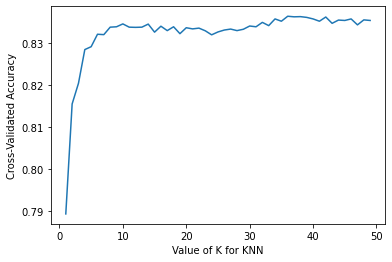

In [53]:
grid_mean_scores = gridsearch.cv_results_['mean_test_score']
plt.plot(k_range, grid_mean_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

Fold #1
ROC AUC score : 0.863
Kappa score   : 0.488
F1 score      : 0.601
Accuracy      : 0.823
Precision      : 0.647
Recall      : 0.561
------------------------------
Fold #2
ROC AUC score : 0.874
Kappa score   : 0.508
F1 score      : 0.612
Accuracy      : 0.835
Precision      : 0.663
Recall      : 0.569
------------------------------
Fold #3
ROC AUC score : 0.861
Kappa score   : 0.516
F1 score      : 0.620
Accuracy      : 0.836
Precision      : 0.635
Recall      : 0.606
------------------------------
Fold #4
ROC AUC score : 0.874
Kappa score   : 0.506
F1 score      : 0.608
Accuracy      : 0.837
Precision      : 0.660
Recall      : 0.563
------------------------------

ROC AUC médio entre os folds  : 0.868
Kappa médio entre os folds    : 0.505
F1 médio entre os folds       : 0.610
Acurácia média entre os folds : 0.833
Precision média entre os folds : 0.651
Recall média entre os folds : 0.575


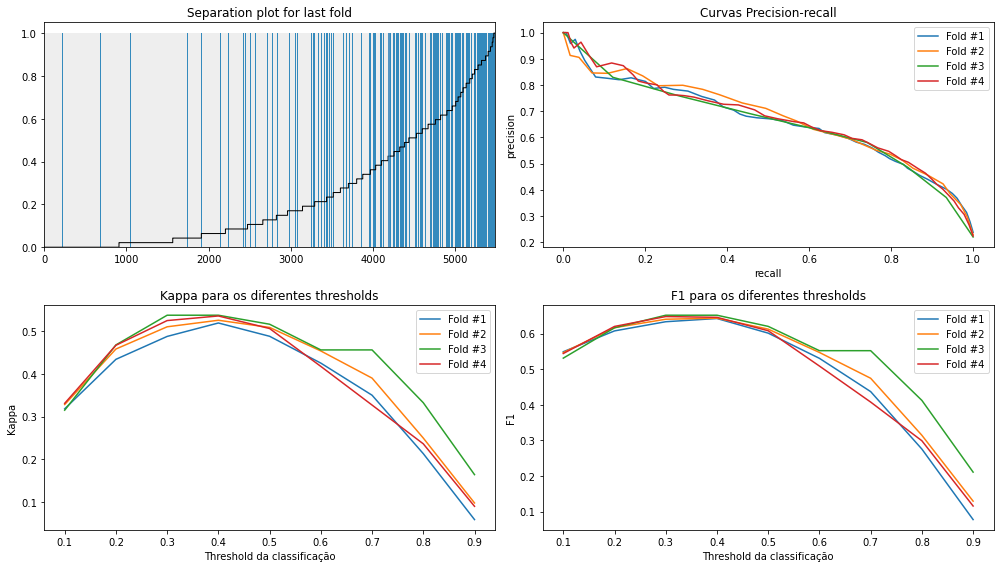

In [54]:
validate_model(gridsearch, X_train, y_train)

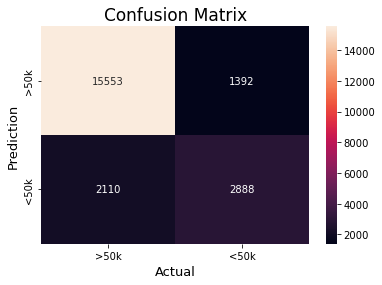

Accuracy   : 0.8404046848653329
Precision : 0.6747663551401869
Recall    : 0.5778311324529812
F1-score  : 0.6225479629230438
ROC AUC  : 0.74784150308102


In [55]:
y_pred = gridsearch.predict(X_train)
plot_confusion_matrix_and_evaluation_metrics(y_train,y_pred)

- Dados de Teste

Fold #1
ROC AUC score : 0.860
Kappa score   : 0.478
F1 score      : 0.578
Accuracy      : 0.835
Precision      : 0.654
Recall      : 0.519
------------------------------
Fold #2
ROC AUC score : 0.868
Kappa score   : 0.484
F1 score      : 0.581
Accuracy      : 0.838
Precision      : 0.695
Recall      : 0.499
------------------------------
Fold #3
ROC AUC score : 0.853
Kappa score   : 0.435
F1 score      : 0.537
Accuracy      : 0.830
Precision      : 0.620
Recall      : 0.473
------------------------------
Fold #4
ROC AUC score : 0.851
Kappa score   : 0.464
F1 score      : 0.573
Accuracy      : 0.824
Precision      : 0.650
Recall      : 0.513
------------------------------

ROC AUC médio entre os folds  : 0.858
Kappa médio entre os folds    : 0.465
F1 médio entre os folds       : 0.567
Acurácia média entre os folds : 0.832
Precision média entre os folds : 0.655
Recall média entre os folds : 0.501


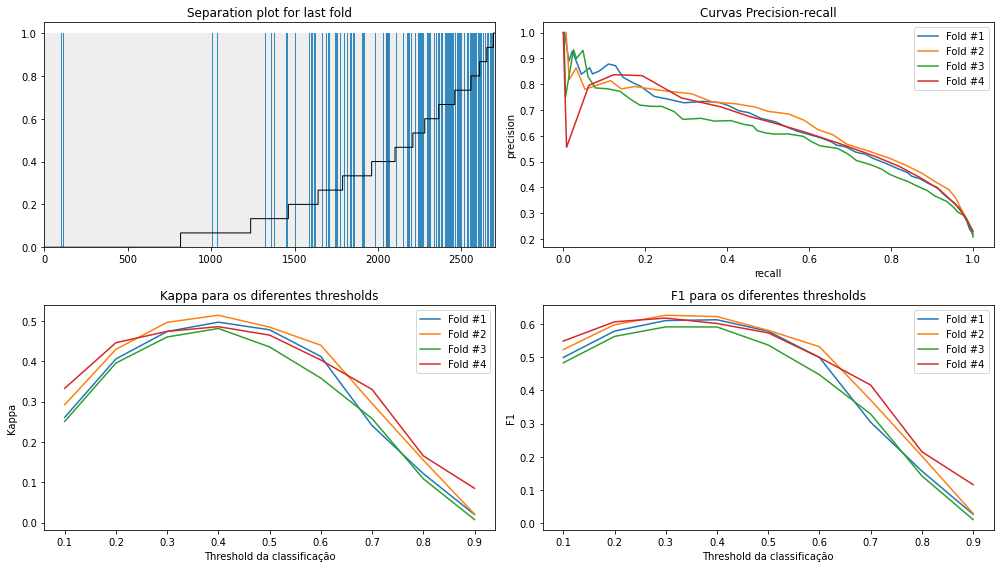

In [56]:
validate_model(gridsearch, X_test, y_test)

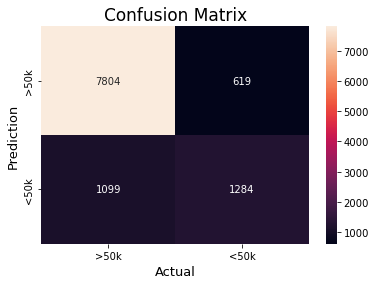

Accuracy   : 0.8410142513418472
Precision : 0.674724119810825
Recall    : 0.5388166177087704
F1-score  : 0.5991600559962669
ROC AUC  : 0.7326636810495651


In [57]:
y_pred = gridsearch.predict(X_test)
plot_confusion_matrix_and_evaluation_metrics(y_test,y_pred)

##### Desempenho melhor configuração

In [58]:
var = gridsearch.best_params_
var['n_neighbors']

15

In [59]:
model = KNeighborsClassifier(n_neighbors = var['n_neighbors'], metric = 'minkowski', p = 2) #Minkowski
model

KNeighborsClassifier(n_neighbors=15)

- Dados de Treino

Fold #1
ROC AUC score : 0.871
Kappa score   : 0.520
F1 score      : 0.623
Accuracy      : 0.838
Precision      : 0.666
Recall      : 0.585
------------------------------
Fold #2
ROC AUC score : 0.876
Kappa score   : 0.519
F1 score      : 0.624
Accuracy      : 0.836
Precision      : 0.659
Recall      : 0.593
------------------------------
Fold #3
ROC AUC score : 0.858
Kappa score   : 0.487
F1 score      : 0.596
Accuracy      : 0.827
Precision      : 0.636
Recall      : 0.560
------------------------------
Fold #4
ROC AUC score : 0.868
Kappa score   : 0.511
F1 score      : 0.616
Accuracy      : 0.834
Precision      : 0.644
Recall      : 0.590
------------------------------

ROC AUC médio entre os folds  : 0.868
Kappa médio entre os folds    : 0.509
F1 médio entre os folds       : 0.615
Acurácia média entre os folds : 0.834
Precision média entre os folds : 0.651
Recall média entre os folds : 0.582


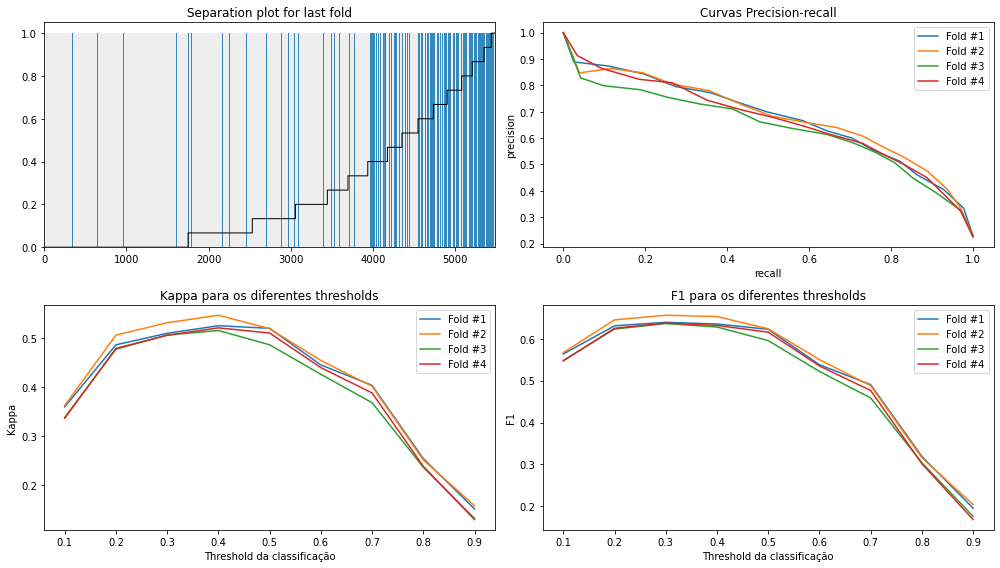

In [60]:
validate_model(model, X_train, y_train)

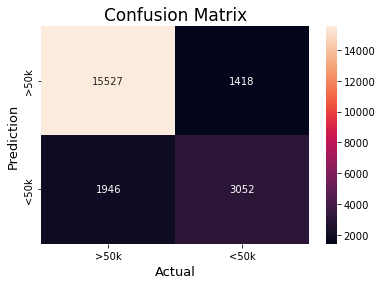

Accuracy   : 0.8466937064211821
Precision : 0.6827740492170022
Recall    : 0.6106442577030813
F1-score  : 0.6446979298690326
ROC AUC  : 0.7634808777450195


In [61]:
y_pred = model.predict(X_train)
plot_confusion_matrix_and_evaluation_metrics(y_train,y_pred)

- Dados de Teste

Fold #1
ROC AUC score : 0.842
Kappa score   : 0.437
F1 score      : 0.551
Accuracy      : 0.817
Precision      : 0.606
Recall      : 0.505
------------------------------
Fold #2
ROC AUC score : 0.864
Kappa score   : 0.500
F1 score      : 0.601
Accuracy      : 0.839
Precision      : 0.624
Recall      : 0.580
------------------------------
Fold #3
ROC AUC score : 0.854
Kappa score   : 0.464
F1 score      : 0.567
Accuracy      : 0.830
Precision      : 0.663
Recall      : 0.495
------------------------------
Fold #4
ROC AUC score : 0.849
Kappa score   : 0.458
F1 score      : 0.571
Accuracy      : 0.820
Precision      : 0.615
Recall      : 0.533
------------------------------

ROC AUC médio entre os folds  : 0.852
Kappa médio entre os folds    : 0.465
F1 médio entre os folds       : 0.573
Acurácia média entre os folds : 0.826
Precision média entre os folds : 0.627
Recall média entre os folds : 0.528


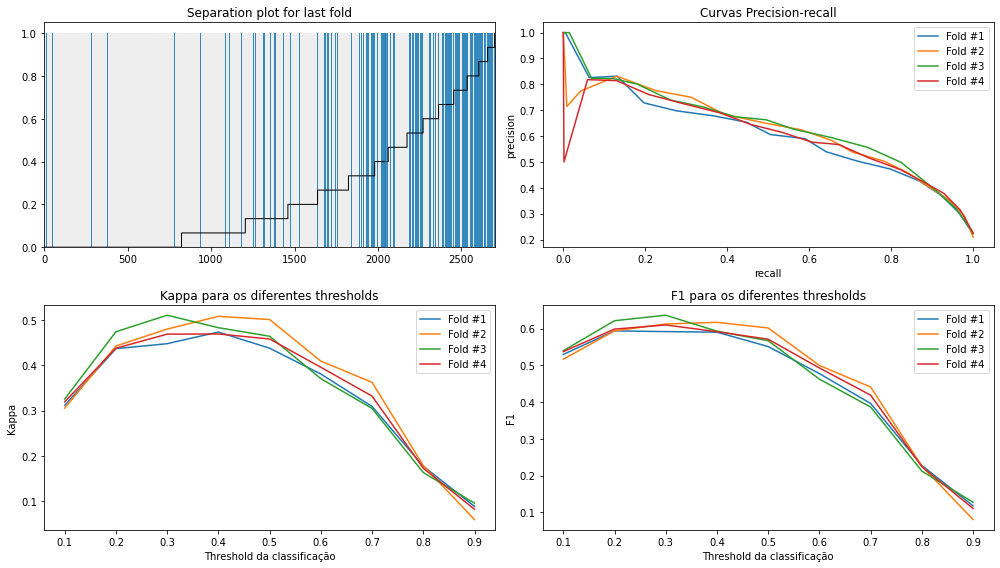

In [62]:
X_test = sc.fit_transform(X_test)
validate_model(model, X_test, y_test)

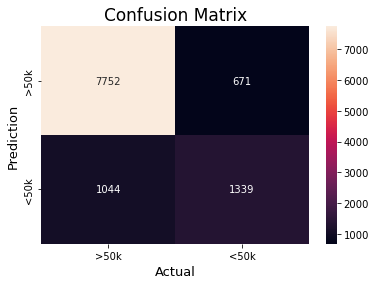

Accuracy   : 0.8412918748843236
Precision : 0.6661691542288557
Recall    : 0.5618967687788502
F1-score  : 0.6096061916685637
ROC AUC  : 0.7411169704039093


In [63]:
y_pred = model.predict(X_test)
plot_confusion_matrix_and_evaluation_metrics(y_test,y_pred)

- dentre as combinações possíveis para tratamento de nulos e da conversão dos atributos categóricos em numéricos a configuração que apresentou melhor desempenho para o KNN foi preenchimento dos nulos com a moda e one-hot-enconding com acurácia de 84.16% para base de treino e 83.4 para de testes. As demais configurações foram:

| Categorigal2Numeric | Nulls | Acurácia(Trn) | ROC(Trn) | Acurácia(Tst) | ROC(Tst) | # Registros | # Treino | # Teste
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| One-hot-enconding | DROP | 83.6% | 87.4% | 83.0% | 85.4% | 32749 | 21943 | 10806|
| One-hot-enconding | Mode | 83.7% | 86.9% | 83.4% | 85.9% | 35188 | 23571 | 11617 |
| Label-encoded | DROP | 84.8% | 82.3% | 80.9% | 82.0% | 32749 | 21943 | 10806 |
| Label-encoded | Mode | 85.0% | 82.5% | 82.7% | 81.7% | 35188 | 23571 | 11617 |

- Todas as configurações utilizaram normalização dos dados
- O tempo de processamento com label-encoded foi menor que as configurações com one-hot-encoding

#### Gradient Boosted Trees

C:\Users\cazev\miniconda3\envs\cashme\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold #1
ROC AUC score : 0.897
Kappa score   : 0.553
F1 score      : 0.645
Accuracy      : 0.852
Precision      : 0.717
Recall      : 0.586
------------------------------


C:\Users\cazev\miniconda3\envs\cashme\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold #2
ROC AUC score : 0.899
Kappa score   : 0.568
F1 score      : 0.657
Accuracy      : 0.857
Precision      : 0.720
Recall      : 0.605
------------------------------


C:\Users\cazev\miniconda3\envs\cashme\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold #3
ROC AUC score : 0.894
Kappa score   : 0.546
F1 score      : 0.643
Accuracy      : 0.846
Precision      : 0.693
Recall      : 0.600
------------------------------


C:\Users\cazev\miniconda3\envs\cashme\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold #4
ROC AUC score : 0.891
Kappa score   : 0.540
F1 score      : 0.636
Accuracy      : 0.847
Precision      : 0.681
Recall      : 0.597
------------------------------

ROC AUC médio entre os folds  : 0.895
Kappa médio entre os folds    : 0.552
F1 médio entre os folds       : 0.646
Acurácia média entre os folds : 0.851
Precision média entre os folds : 0.703
Recall média entre os folds : 0.597


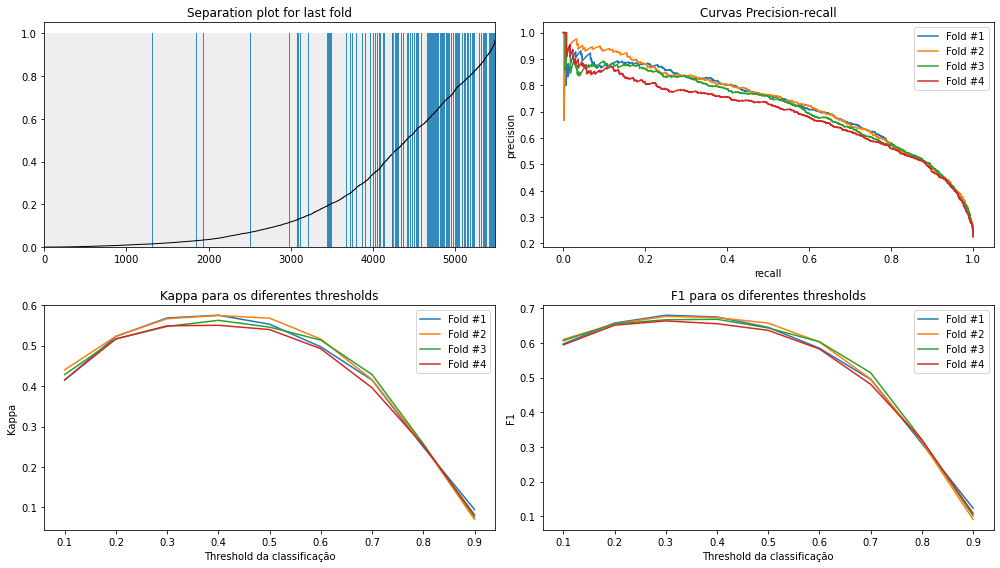

In [64]:
# Looks like default values give good enough result improvements
model  = lgb.LGBMClassifier()
validate_model(model, X_train, y_train)

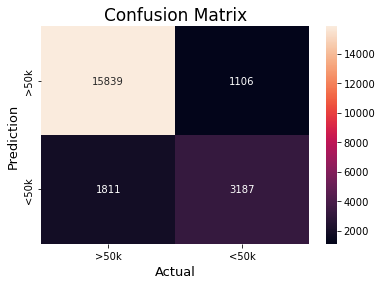

Accuracy   : 0.8670646675477374
Precision : 0.7423713021197298
Recall    : 0.6376550620248099
F1-score  : 0.6860402540092562
ROC AUC  : 0.7861925354384893


In [65]:
y_pred = model.predict(X_train)
plot_confusion_matrix_and_evaluation_metrics(y_train,y_pred)

C:\Users\cazev\miniconda3\envs\cashme\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold #1
ROC AUC score : 0.871
Kappa score   : 0.465
F1 score      : 0.569
Accuracy      : 0.829
Precision      : 0.652
Recall      : 0.504
------------------------------


C:\Users\cazev\miniconda3\envs\cashme\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold #2
ROC AUC score : 0.886
Kappa score   : 0.530
F1 score      : 0.630
Accuracy      : 0.841
Precision      : 0.699
Recall      : 0.573
------------------------------


C:\Users\cazev\miniconda3\envs\cashme\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold #3
ROC AUC score : 0.886
Kappa score   : 0.498
F1 score      : 0.599
Accuracy      : 0.838
Precision      : 0.655
Recall      : 0.551
------------------------------


C:\Users\cazev\miniconda3\envs\cashme\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold #4
ROC AUC score : 0.884
Kappa score   : 0.514
F1 score      : 0.608
Accuracy      : 0.848
Precision      : 0.639
Recall      : 0.580
------------------------------

ROC AUC médio entre os folds  : 0.882
Kappa médio entre os folds    : 0.502
F1 médio entre os folds       : 0.601
Acurácia média entre os folds : 0.839
Precision média entre os folds : 0.662
Recall média entre os folds : 0.552


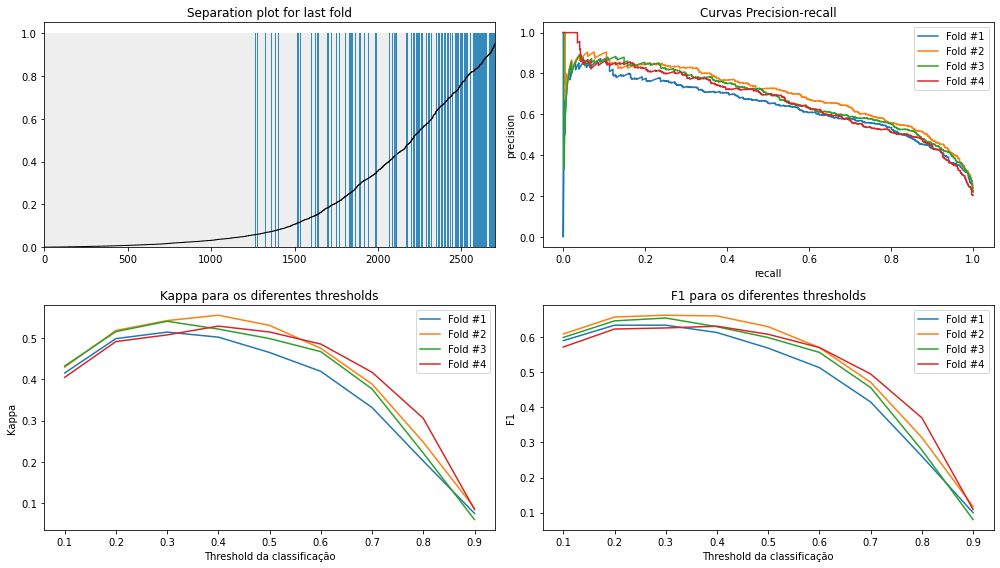

In [66]:
validate_model(model, X_test, y_test)

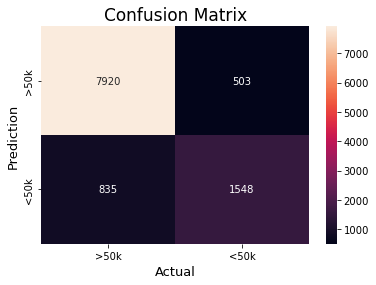

Accuracy   : 0.8761799000555247
Precision : 0.7547537786445636
Recall    : 0.6496013428451531
F1-score  : 0.6982408660351827
ROC AUC  : 0.7949419512516162


In [67]:
y_pred = model.predict(X_test)
plot_confusion_matrix_and_evaluation_metrics(y_test,y_pred)

#### Decision Tree

ref.
 - https://www.projectpro.io/recipes/optimize-hyper-parameters-of-decisiontree-model-using-grid-search-in-python

##### Tuning dos hiper-parametros

In [68]:
from sklearn.tree import DecisionTreeClassifier
#n_components = list(range(1,X_train.shape[1]+1,1))
#criterion = ['gini', 'entropy']
#max_depth = [4,6,8,10,12,14]

In [69]:
#parameters = {
#    'criterion': criterion,
#    'max_depth': max_depth,
#    'min_samples_split': range(1,10),
#    'min_samples_leaf': range(1,5)
#}

In [ ]:
parameters = {'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [5, 6, 7, 8, 9,12],
              'criterion' :['gini', 'entropy']
             }

In [ ]:
tree_clas = DecisionTreeClassifier(random_state=1024)
gridsearch = GridSearchCV(estimator=tree_clas, param_grid=param_grid, cv=5, verbose=True)
gridsearch.fit(X_train, y_train)

In [70]:
#gridsearch = GridSearchCV(KNeighborsClassifier(), parameters, cv=10, scoring='accuracy', return_train_score=False)
#gridsearch = GridSearchCV(DecisionTreeClassifier(), parameters, scoring='accuracy')
#gridsearch.fit(X_train, y_train)

C:\Users\cazev\miniconda3\envs\cashme\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
240 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\cazev\miniconda3\envs\cashme\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\cazev\miniconda3\envs\cashme\lib\site-packages\sklearn\tree\_classes.py", line 889, in fit
    super().fit(
  File "C:\Users\cazev\miniconda3\envs\cashme\lib\site-packages\sklearn\tree\_classes.py", line 177, in fit
    self._validate_params()
  File "C:\Users\ca

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8, 10, 12, 14],
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(1, 10)},
             scoring='accuracy')

In [71]:
#grid_mean_scores = gridsearch.cv_results_['mean_test_score']
#plt.plot(max_depth, grid_mean_scores)
#plt.xlabel('Value of K for DecisionTree')
#plt.ylabel('Cross-Validated Accuracy')

C:\Users\cazev\miniconda3\envs\cashme\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
240 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\cazev\miniconda3\envs\cashme\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\cazev\miniconda3\envs\cashme\lib\site-packages\sklearn\tree\_classes.py", line 889, in fit
    super().fit(
  File "C:\Users\cazev\miniconda3\envs\cashme\lib\site-packages\sklearn\tree\_classes.py", line 177, in fit
    self._validate_params()
  File "C:\Users\ca

Fold #1
ROC AUC score : 0.859
Kappa score   : 0.498
F1 score      : 0.600
Accuracy      : 0.837
Precision      : 0.646
Recall      : 0.559
------------------------------


C:\Users\cazev\miniconda3\envs\cashme\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
240 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\cazev\miniconda3\envs\cashme\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\cazev\miniconda3\envs\cashme\lib\site-packages\sklearn\tree\_classes.py", line 889, in fit
    super().fit(
  File "C:\Users\cazev\miniconda3\envs\cashme\lib\site-packages\sklearn\tree\_classes.py", line 177, in fit
    self._validate_params()
  File "C:\Users\ca

Fold #2
ROC AUC score : 0.874
Kappa score   : 0.538
F1 score      : 0.645
Accuracy      : 0.835
Precision      : 0.662
Recall      : 0.628
------------------------------


C:\Users\cazev\miniconda3\envs\cashme\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
240 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\cazev\miniconda3\envs\cashme\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\cazev\miniconda3\envs\cashme\lib\site-packages\sklearn\tree\_classes.py", line 889, in fit
    super().fit(
  File "C:\Users\cazev\miniconda3\envs\cashme\lib\site-packages\sklearn\tree\_classes.py", line 177, in fit
    self._validate_params()
  File "C:\Users\ca

Fold #3
ROC AUC score : 0.863
Kappa score   : 0.493
F1 score      : 0.598
Accuracy      : 0.832
Precision      : 0.657
Recall      : 0.548
------------------------------


C:\Users\cazev\miniconda3\envs\cashme\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
240 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\cazev\miniconda3\envs\cashme\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\cazev\miniconda3\envs\cashme\lib\site-packages\sklearn\tree\_classes.py", line 889, in fit
    super().fit(
  File "C:\Users\cazev\miniconda3\envs\cashme\lib\site-packages\sklearn\tree\_classes.py", line 177, in fit
    self._validate_params()
  File "C:\Users\ca

Fold #4
ROC AUC score : 0.858
Kappa score   : 0.486
F1 score      : 0.596
Accuracy      : 0.826
Precision      : 0.632
Recall      : 0.563
------------------------------

ROC AUC médio entre os folds  : 0.863
Kappa médio entre os folds    : 0.503
F1 médio entre os folds       : 0.609
Acurácia média entre os folds : 0.833
Precision média entre os folds : 0.649
Recall média entre os folds : 0.575


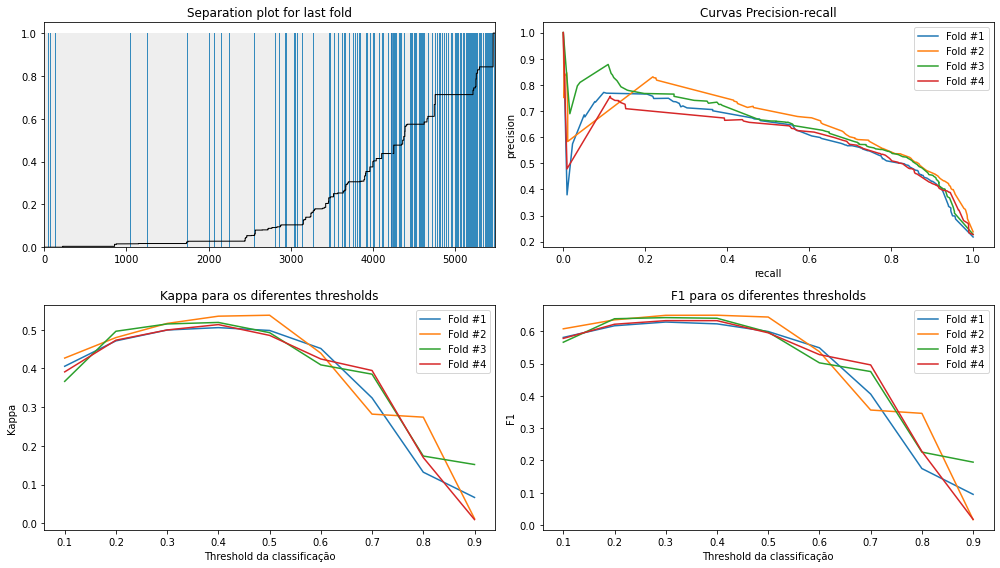

In [72]:
validate_model(gridsearch, X_train, y_train)

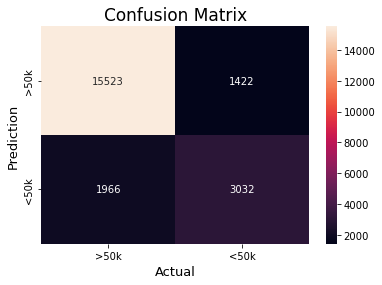

Accuracy   : 0.845599963541904
Precision : 0.6807364167040862
Recall    : 0.6066426570628252
F1-score  : 0.641557342361405
ROC AUC  : 0.7613620485078069


In [73]:
y_pred = gridsearch.predict(X_train)
plot_confusion_matrix_and_evaluation_metrics(y_train,y_pred)

In [74]:
gridsearch.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'min_samples_leaf': 2,
 'min_samples_split': 8}

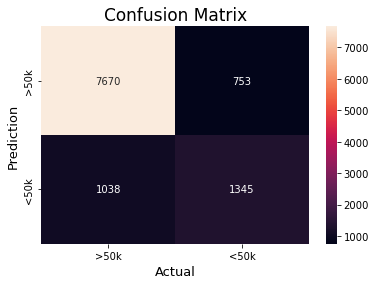

Accuracy   : 0.834258745141588
Precision : 0.6410867492850334
Recall    : 0.5644146034410407
F1-score  : 0.6003124302611024
ROC AUC  : 0.7375082633731382


In [75]:
y_pred = gridsearch.predict(X_test)
plot_confusion_matrix_and_evaluation_metrics(y_test,y_pred)

##### Desempenho melhor configuração

Fold #1
ROC AUC score : 0.862
Kappa score   : 0.494
F1 score      : 0.595
Accuracy      : 0.837
Precision      : 0.657
Recall      : 0.544
------------------------------
Fold #2
ROC AUC score : 0.855
Kappa score   : 0.470
F1 score      : 0.575
Accuracy      : 0.829
Precision      : 0.659
Recall      : 0.511
------------------------------
Fold #3
ROC AUC score : 0.838
Kappa score   : 0.420
F1 score      : 0.532
Accuracy      : 0.817
Precision      : 0.602
Recall      : 0.476
------------------------------
Fold #4
ROC AUC score : 0.858
Kappa score   : 0.385
F1 score      : 0.486
Accuracy      : 0.821
Precision      : 0.643
Recall      : 0.391
------------------------------

ROC AUC médio entre os folds  : 0.853
Kappa médio entre os folds    : 0.442
F1 médio entre os folds       : 0.547
Acurácia média entre os folds : 0.826
Precision média entre os folds : 0.640
Recall média entre os folds : 0.480


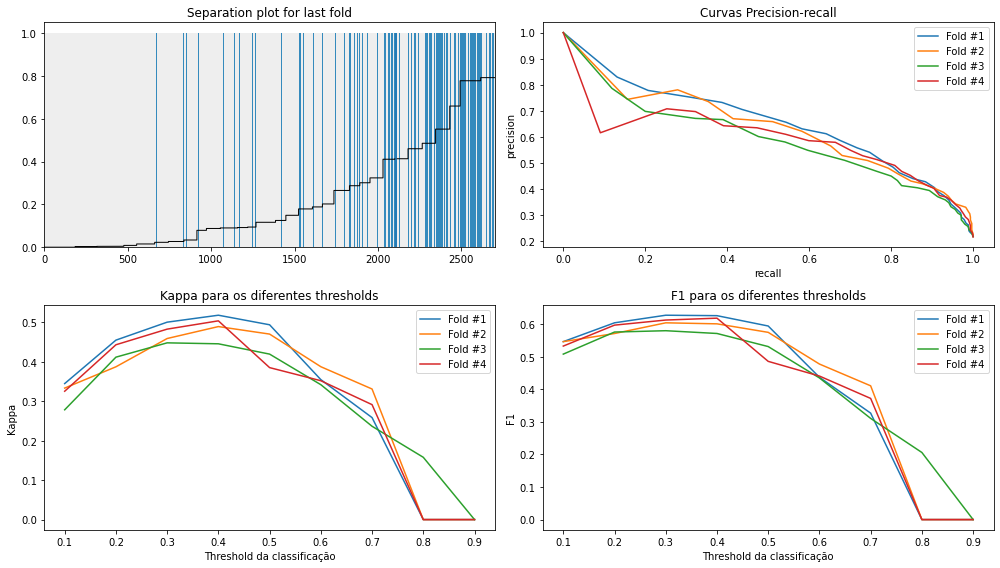

In [77]:
model = DecisionTreeClassifier(
    min_samples_leaf=200,
    criterion='gini',
)
validate_model(model, X_test, y_test)

####  Random Forest

In [78]:
model = RandomForestClassifier()

In [79]:
model.fit(X_train,y_train)

RandomForestClassifier()

Fold #1
ROC AUC score : 0.866
Kappa score   : 0.493
F1 score      : 0.600
Accuracy      : 0.830
Precision      : 0.653
Recall      : 0.554
------------------------------
Fold #2
ROC AUC score : 0.869
Kappa score   : 0.497
F1 score      : 0.603
Accuracy      : 0.831
Precision      : 0.661
Recall      : 0.554
------------------------------
Fold #3
ROC AUC score : 0.874
Kappa score   : 0.497
F1 score      : 0.602
Accuracy      : 0.831
Precision      : 0.672
Recall      : 0.546
------------------------------
Fold #4
ROC AUC score : 0.874
Kappa score   : 0.507
F1 score      : 0.605
Accuracy      : 0.842
Precision      : 0.663
Recall      : 0.556
------------------------------

ROC AUC médio entre os folds  : 0.871
Kappa médio entre os folds    : 0.498
F1 médio entre os folds       : 0.602
Acurácia média entre os folds : 0.834
Precision média entre os folds : 0.662
Recall média entre os folds : 0.553


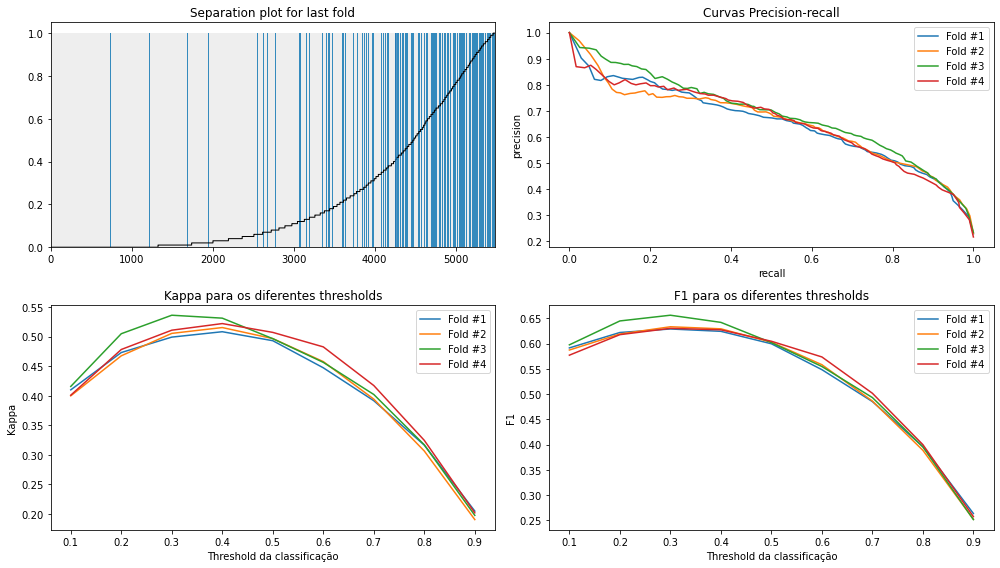

In [80]:
validate_model(model, X_train, y_train)

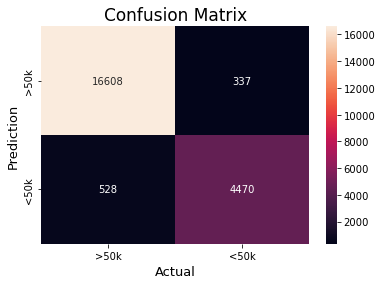

Accuracy   : 0.9605796837260174
Precision : 0.9298939047222801
Recall    : 0.8943577430972389
F1-score  : 0.9117797042325345
ROC AUC  : 0.9372349352842346


In [81]:
y_pred = model.predict(X_train)
plot_confusion_matrix_and_evaluation_metrics(y_train,y_pred)

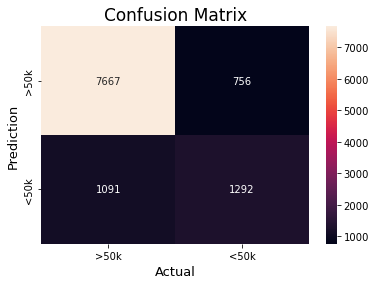

Accuracy   : 0.8290764390153619
Precision : 0.630859375
Recall    : 0.5421737305916912
F1-score  : 0.5831640713157301
ROC AUC  : 0.7262097431303464


In [82]:
y_pred = model.predict(X_test)
plot_confusion_matrix_and_evaluation_metrics(y_test,y_pred)

#### SVM

ref:
    - https://www.vebuso.com/2020/03/svm-hyperparameter-tuning-using-gridsearchcv/

##### Tuning do hiper-parametros

In [83]:
#param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
#param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001],'kernel': ['rbf']}
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001],'kernel': ['rbf']}

In [84]:
gridsearch = GridSearchCV(SVC(),param_grid,refit=True,verbose=3)
gridsearch.fit(X_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.788 total time= 1.2min
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.789 total time= 1.1min
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.788 total time=  59.9s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.785 total time=  52.3s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.787 total time=  56.9s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.820 total time=  33.2s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.815 total time=  42.2s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.819 total time=  35.1s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.813 total time=  39.7s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.811 total time=  32.7s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.843 total time=  14.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

KeyboardInterrupt: 

In [ ]:
print(gridsearch.best_estimator_)

In [ ]:
print(gridsearch.best_params_)

In [ ]:
validate_model(gridsearch, X_train, y_train)

In [ ]:
y_pred = gridsearch.predict(X_train)
plot_confusion_matrix_and_evaluation_metrics(y_train,y_pred)

In [ ]:
print(classification_report(y_train, y_pred))

In [ ]:
validate_model(gridsearch, X_test, y_test)

In [ ]:
y_pred = gridsearch.predict(X_test)
plot_confusion_matrix_and_evaluation_metrics(y_test,y_pred)

In [ ]:
print(classification_report(y_test, y_pred))

####  Neural Network

### Evaluating test dataset

In [ ]:
n_train_samples = len(train_data)
fold_metrics = defaultdict(list)
# In every model probability threshold 0.3 and 0.4 showed best results
# For this reason we will use one threshold equal to 0.35
thresholds = np.array([0.35])
data = pd.concat([train_data, test_data], ignore_index=True)
X, y, feature_names = features_with_labeled_categories(data, num_col,cat_col)
X_train, y_train = X[:n_train_samples], y[:n_train_samples]
X_test, y_test = X[n_train_samples:], y[n_train_samples:]

In [ ]:
len(X_test)

In [ ]:
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)

y_predicted_probas = model.predict_proba(X_test)
y_predicted_proba = y_predicted_probas[:, 1]

collect_metrics(fold_metrics, y_test, y_predicted_proba, thresholds)
print_last_fold_stats(fold_metrics)

## Analyze models decisions

In [ ]:
import shap
shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, feature_names)

In [ ]:
shap.summary_plot(shap_values, X, feature_names, plot_type='bar')

Observations:

The education column mostly duplicates information obtained from the education_num column, that's probably why it has low impact.

Native country contains mostly US and other countries probably don't have large impact on the outcome.

Race also looks like a strange variable to use for outcome prediction.